In [1]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# IMPORT PACKAGES

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as feature
import cmocean.cm
import pandas as pd
import xarray as xr
import collections
from scipy.stats import ttest_ind, ttest_rel
import pickle
# fix to cartopy issue right now
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

In [3]:
# ADDITIONAL FUNCTIONS

# CODE TO CALCULATE SEASONAL AVERAGE AND STATISTICAL SIGNIFICANCE

# Taken from: https://xarray.pydata.org/en/v0.14.0/examples/monthly-means.html
# However test plot in "Seasonal Mean Example" produces somewhat different results-- not sure why.
# usage example: ds_weighted = season_mean(ds,calendar='noleap')

dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30],
       'julian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def season_mean(ds, calendar='standard'):

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

def annual_season_mean(ds, calendar='standard'): # Added 7-9-20
    # TRUNCATE TIME SERIES IN ADVANCE SO THERE ARE ONLY COMPLETE YEARS, OTHERWISE GET INF/0 AT END FOR SOME SEASONS
    ml = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length') # ml stands for month_length
    ml_seas = {}
    ml_seas_sums = {}
    weights = {}
    ds_seas = {}
    ann_seas_mean_v1 = {}
    for seas in ['DJF','MAM','JJA','SON']:
        ml_seas[seas] = ml.where(ds['time.season'] == seas)
        ml_seas_sums[seas] = ml_seas[seas].rolling(min_periods=3, center=True, time=3).sum()
        if seas == 'DJF':
            ml_seas[seas] = ml_seas[seas].shift(time=1) # done to ensure weights for consecutive D-J-F add up to 1 despite crossing year
        weights[seas] = ml_seas[seas].groupby('time.year') / ml_seas_sums[seas].groupby('time.year').sum()
        
        ds_seas[seas] = ds.where(ds['time.season'] == seas)
        if seas == 'DJF':
            ds_seas[seas] = ds_seas[seas].shift(time=1)
        ann_seas_mean_v1[seas] = (ds_seas[seas] * weights[seas]).groupby('time.year').sum(dim='time') # 0 AT END IF NOT COMPLETE YEAR
    ann_seas_mean_v1['DJF'] = ann_seas_mean_v1['DJF'].isel(year=slice(1,len(ann_seas_mean_v1['DJF'].year)))
    return ann_seas_mean_v1

#STATISTICAL SIGNIFICANCE TEST
#test with identical sample sizes

def sigtest(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_rel(yearmean1,yearmean2, axis=0)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff,diff_mask,ptvals

def sigtest2n(yearmean1,yearmean2,timemean1,timemean2):
    ptvals = ttest_ind(yearmean1,yearmean2, axis=0, equal_var = False)
    diff = timemean1-timemean2
    diff_mask = np.ma.masked_where(ptvals[1] > 0.1,diff)
    return diff,diff_mask,ptvals

# CODE TO SHIFT CCSM DATA BY 1 MONTH (given weird NCAR conventions that calendar date is end of time bound for each month)

def shift_dates_1M(dat):
    y_first = str(dat.time.values[0].year).zfill(4)
    y_last = str(dat.time.values[-2].year).zfill(4)

    time2 = xr.cftime_range(start=str(y_first)+'-01-01', end=str(y_last)+'-12-01', freq="1MS", calendar="noleap")
    dat = dat.assign_coords(time=time2)
    return dat


In [4]:
# PATHS TO DATA FILES

# direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
# diagu = 'ucomp'
# diagv = 'vcomp'
# #diagwind = 'wind'
# filesu = {}
# filesv = {}
# #filesws = {}

# filesu['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/'+diagu+'.00010101-03000101.atmos_month.nc'
# filesu['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/'+diagu+'.00010101-02050101.atmos_month.nc'
# filesu['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/'+diagu+'.00010101-06000101.atmos_month.nc'
# filesu['obs'] = '/tigress/janewb/OBS/MERRA2/MERRA2.UV.nc'
# filesu['cesm_ctrl'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.cam2.h0.U.120001-130012.nc'
# filesu['cesm_cam'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.cam2.h0.U.020001-029912.nc'

# filesv['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/'+diagv+'.00010101-03000101.atmos_month.nc'
# filesv['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/'+diagv+'.00010101-02050101.atmos_month.nc'
# filesv['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/'+diagv+'.00010101-06000101.atmos_month.nc'
# filesv['obs'] = '/tigress/janewb/OBS/MERRA2/MERRA2.UV.nc'
# filesv['cesm_ctrl'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/b40.1850.track1.1deg.006.cam2.h0.V.120001-130012.nc'
# filesv['cesm_cam'] = '/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_data/ccsm4pi_topo2.cam2.h0.V.020001-029912.nc'

# filesws['ctrl'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/'+diagwind+'.00010101-03000101.atmos_month.nc'
# filesws['cam'] = '/tigress/janewb/MODEL_OUT_HERE/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/'+diagwind+'.00010101-02050101.atmos_month.nc'
# filesws['hitopo'] = direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/'+diagwind+'.00010101-06000101.atmos_month.nc'
# filesws['obs'] = '/tigress/janewb/OBS/MERRA2/MERRA2.SPEEDLML.nc'
# # truncated time series using nco because points from 989 on were corrupted

direc = '/tigress/janewb/public_html/HITOPO/'
diagu = 'ucomp'
diagv = 'vcomp'
filesu = {}
filesv = {}

filesu['ctrl'] = direc+'flor.ctrl.ucomp.nc'
filesu['cam'] = direc+'flor.cam.ucomp.nc'
filesu['hitopo'] = direc+'flor.hitopo.ucomp.nc'
filesu['obs'] = direc+'obs.merra2.ucomp-vcomp.nc'
filesu['cesm_ctrl'] = direc+'ccsm4.ctrl.ucomp.nc'
filesu['cesm_cam'] = direc+'ccsm4.ideal_cam.ucomp.nc'

filesv['ctrl'] = direc+'flor.ctrl.vcomp.nc'
filesv['cam'] = direc+'flor.cam.vcomp.nc'
filesv['hitopo'] = direc+'flor.hitopo.vcomp.nc'
filesv['obs'] = direc+'obs.merra2.ucomp-vcomp.nc'
filesv['cesm_ctrl'] = direc+'ccsm4.ctrl.vcomp.nc'
filesv['cesm_cam'] = direc+'ccsm4.ideal_cam.vcomp.nc'


In [161]:
# DATA CLEANING, INCLUDING SELECTING LOWEST LEVEL IN THE ATMOSPHERE
x = 'lon'
y = 'lat'
model_tmin = '0031'
model_tmax = '0200'
obs_tmin = '1980'
obs_tmax = '2019'
units = 'm/s'
calendars = {'ctrl':'noleap',
             'cam':'noleap',
             'hitopo':'noleap',
             'obs':'gregorian',
             'cesm_ctrl':'noleap',
             'cesm_cam':'noleap'
            }

datu = {}
datv = {}
datws = {}
u = {}
v = {}
ws = {}
tselu = {}
tselv = {}
tselws = {}

# FLOR Runs
for key in ['ctrl','cam','hitopo']:
    datu[key] = xr.open_dataset(filesu[key])
    datu[key] = datu[key].rename({'ucomp':'u'}).isel(pfull=0) # select lowest level in the atmosphere 996.1 hPa
    u[key] = datu[key].u
    u[key].attrs = datu[key].attrs
    u[key] = u[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
    tselu[key] = u[key].sel(time = slice(model_tmin,model_tmax))    
for key in ['ctrl','cam','hitopo']:
    datv[key] = xr.open_dataset(filesv[key])
    datv[key] = datv[key].rename({'vcomp':'v'}).isel(pfull=0) # select lowest level in the atmosphere 996.1 hPa
    v[key] = datv[key].v
    v[key].attrs = datv[key].attrs
    v[key] = v[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
    tselv[key] = v[key].sel(time = slice(model_tmin,model_tmax))
'''
for key in ['ctrl','cam','hitopo']:
    datws[key] = xr.open_dataset(filesws[key])
    datws[key] = datws[key].rename({'wind':'ws'})
    ws[key] = datws[key].ws
    ws[key].attrs = datws[key].attrs
    ws[key] = ws[key].rename({'grid_xt': 'lon','grid_yt': 'lat'})
    tselws[key] = ws[key].sel(time = slice(model_tmin,model_tmax))
'''   
# CESM RUNS
for key in ['cesm_ctrl','cesm_cam']:
    datu[key] = xr.open_dataset(filesu[key])
    datu[key] = shift_dates_1M(datu[key])
    datu[key] = datu[key].rename({'U':'u'}).isel(lev=0) # select lowest level in the atmosphere 992.6 hPa
    u[key] = datu[key].u
    u[key].attrs = datu[key].attrs
    tselu[key] = u[key]
for key in ['cesm_ctrl','cesm_cam']:
    datv[key] = xr.open_dataset(filesv[key])
    datv[key] = shift_dates_1M(datv[key])
    datv[key] = datv[key].rename({'V':'v'}).isel(lev=0) # select lowest level in the atmosphere 992.6 hPa
    v[key] = datv[key].v
    v[key].attrs = datv[key].attrs
    tselv[key] = v[key]
'''
for key in ['cesm_ctrl','cesm_cam']:
    datws[key] = xr.open_dataset(filesws[key])
    datws[key] = datws[key].rename({'UVEL':'ws'}) # this is actually velocity in the grid, x-direction
    ws[key] = datws[key].ws*1/100 #convert cm/s to m/s
    ws[key].attrs = datws[key].attrs
    ws[key].attrs['units'] = units
    tselws[key] = ws[key]
'''   
# OBSERVATIONS: MERRA2

datu['obs'] = xr.open_dataset(filesu['obs'])
datu['obs'] = datu['obs'].assign_coords(lon=(datu['obs'].lon % 360)).roll(lon=287, roll_coords=True)
datu['obs'] = datu['obs'].rename({'U':'u'})#.isel(lev=0) # select lowest level 1000 hPa
u['obs'] = datu['obs'].u
u['obs'].attrs = datu['obs'].attrs
tselu['obs'] = u['obs'].sel(time = slice(obs_tmin,obs_tmax))

datv['obs'] = xr.open_dataset(filesv['obs'])
datv['obs'] = datv['obs'].assign_coords(lon=(datv['obs'].lon % 360)).roll(lon=287, roll_coords=True)
datv['obs'] = datv['obs'].rename({'V':'v'})#.isel(lev=0) # select lowest level 1000 hPa
v['obs'] = datv['obs'].v
v['obs'].attrs = datv['obs'].attrs
tselv['obs'] = v['obs'].sel(time = slice(obs_tmin,obs_tmax))

'''
datws['obs'] = xr.open_dataset(filesws['obs'])
datws['obs'] = datws['obs'].assign_coords(lon=(datws['obs'].lon % 360)).roll(lon=287, roll_coords=True)
datws['obs'] = datws['obs'].rename({'SPEEDLML':'ws'})
ws['obs'] = datws['obs'].ws
ws['obs'].attrs = datws['obs'].attrs
tselws['obs'] = ws['obs'].sel(time = slice(obs_tmin,obs_tmax))
'''


"\ndatws['obs'] = xr.open_dataset(filesws['obs'])\ndatws['obs'] = datws['obs'].assign_coords(lon=(datws['obs'].lon % 360)).roll(lon=287, roll_coords=True)\ndatws['obs'] = datws['obs'].rename({'SPEEDLML':'ws'})\nws['obs'] = datws['obs'].ws\nws['obs'].attrs = datws['obs'].attrs\ntselws['obs'] = ws['obs'].sel(time = slice(obs_tmin,obs_tmax))\n"

In [162]:
# CALCULATE WIND SPEED
tselws = {}
for key in tselu.keys():
    tselws[key] = np.sqrt(tselu[key]**2 + tselv[key]**2)
    

In [ ]:
# DATA ANALYSIS

tmeanu = {}
seasmeanu = {}
annseasmeanu = {}
tmeanv = {}
seasmeanv = {}
annseasmeanv = {}
tmeanws = {}
seasmeanws = {}
annseasmeanws = {}

for key in tselu.keys():
    tmeanu[key] = tselu[key].mean(dim='time')
    seasmeanu[key] = season_mean(tselu[key],calendar=calendars[key])
    annseasmeanu[key] = annual_season_mean(tselu[key],calendar=calendars[key])
    tmeanv[key] = tselv[key].mean(dim='time')
    seasmeanv[key] = season_mean(tselv[key],calendar=calendars[key])
    annseasmeanv[key] = annual_season_mean(tselv[key],calendar=calendars[key])
    tmeanws[key] = tselws[key].mean(dim='time')
    seasmeanws[key] = season_mean(tselws[key],calendar=calendars[key])
    annseasmeanws[key] = annual_season_mean(tselws[key],calendar=calendars[key])


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWar

In [ ]:
# SAVE OUT ANALYZED TIME AND SEASONAL MEAN DATA

for key in tselu.keys():
    tmeanu[key].to_netcdf('WIND/tmean_ucomp_'+key+'.nc')
    tmeanv[key].to_netcdf('WIND/tmean_vcomp_'+key+'.nc')
    tmeanws[key].to_netcdf('WIND/tmean_ws_'+key+'.nc')
    seasmeanu[key].to_netcdf('WIND/seasmean_ucomp_'+key+'.nc')
    seasmeanv[key].to_netcdf('WIND/seasmean_vcomp_'+key+'.nc')
    seasmeanws[key].to_netcdf('WIND/seasmean_ws_'+key+'.nc')
    pickle.dump(annseasmeanu[key],open(r"WIND/annseasmean_ucomp_"+key+".pickle", "wb"))
    pickle.dump(annseasmeanv[key],open(r"WIND/annseasmean_vcomp_"+key+".pickle", "wb"))
    pickle.dump(annseasmeanws[key],open(r"WIND/annseasmean_ws_"+key+".pickle", "wb"))
    

# After reset and load packages, start from here if prepped and saved out data already!

In [5]:
# LOAD ANALYZED TIME AND SEASONAL MEAN DATA
tmeanu = {}
tmeanv = {}
tmeanws = {}
seasmeanu = {}
seasmeanv = {}
seasmeanws = {}
annseasmeanu = {}
annseasmeanv = {}
annseasmeanws = {}

for key in ['obs','cesm_ctrl','cesm_cam','ctrl','hitopo','cam']:
    tmeanu[key] = xr.open_dataset('WIND/tmean_ucomp_'+key+'.nc').u
    tmeanv[key] = xr.open_dataset('WIND/tmean_vcomp_'+key+'.nc').v
    tmeanws[key] = xr.open_dataset('WIND/tmean_ws_'+key+'.nc').__xarray_dataarray_variable__
    seasmeanu[key] = xr.open_dataset('WIND/seasmean_ucomp_'+key+'.nc').__xarray_dataarray_variable__
    seasmeanv[key] = xr.open_dataset('WIND/seasmean_vcomp_'+key+'.nc').__xarray_dataarray_variable__
    seasmeanws[key] = xr.open_dataset('WIND/seasmean_ws_'+key+'.nc').__xarray_dataarray_variable__
    annseasmeanu[key] = pickle.load(open(r"WIND/annseasmean_ucomp_"+key+".pickle", "rb"))
    annseasmeanv[key] = pickle.load(open(r"WIND/annseasmean_vcomp_"+key+".pickle", "rb"))
    annseasmeanws[key] = pickle.load(open(r"WIND/annseasmean_ws_"+key+".pickle", "rb"))
    

In [6]:
# CALCULATE DIFFERENCE AND STATISTICAL SIGNIFICANCE MASK

diff_mask_u = collections.defaultdict(dict)
diff_mask_cesm_u = collections.defaultdict(dict)
diff_u = collections.defaultdict(dict)
diff_cesm_u = collections.defaultdict(dict)
ptvals_u = collections.defaultdict(dict)
ptvals_cesm_u = collections.defaultdict(dict)
seasmeanu_regrid = {}
annseasmeanu_regrid = collections.defaultdict(dict)

diff_mask_v = collections.defaultdict(dict)
diff_mask_cesm_v = collections.defaultdict(dict)
diff_v = collections.defaultdict(dict)
diff_cesm_v = collections.defaultdict(dict)
ptvals_v = collections.defaultdict(dict)
ptvals_cesm_v = collections.defaultdict(dict)
seasmeanv_regrid = {}
annseasmeanv_regrid = collections.defaultdict(dict)

diff_mask_ws = collections.defaultdict(dict)
diff_mask_cesm_ws = collections.defaultdict(dict)
diff_ws = collections.defaultdict(dict)
diff_cesm_ws = collections.defaultdict(dict)
ptvals_ws = collections.defaultdict(dict)
ptvals_cesm_ws = collections.defaultdict(dict)
seasmeanws_regrid = {}
annseasmeanws_regrid = collections.defaultdict(dict)

seasons = ['MAM','SON']


# COMPARING CONTROL AND TOPO. MODEL RUNS

for key in ['hitopo','cam']:
    for seas in seasons:
        diff_u[key][seas],diff_mask_u[key][seas],ptvals_u[key][seas] = sigtest(annseasmeanu[key][seas],annseasmeanu['ctrl'][seas],seasmeanu[key].sel(season=seas),seasmeanu['ctrl'].sel(season=seas))
        diff_v[key][seas],diff_mask_v[key][seas],ptvals_v[key][seas] = sigtest(annseasmeanv[key][seas],annseasmeanv['ctrl'][seas],seasmeanv[key].sel(season=seas),seasmeanv['ctrl'].sel(season=seas))
        diff_ws[key][seas],diff_mask_ws[key][seas],ptvals_ws[key][seas] = sigtest(annseasmeanws[key][seas],annseasmeanws['ctrl'][seas],seasmeanws[key].sel(season=seas),seasmeanws['ctrl'].sel(season=seas))
       
for seas in seasons:
    diff_u['cesm_cam'][seas],diff_mask_u['cesm_cam'][seas],ptvals_u['cesm_cam'][seas] = sigtest2n(annseasmeanu['cesm_cam'][seas].values,annseasmeanu['cesm_ctrl'][seas].values,seasmeanu['cesm_cam'].sel(season=seas).values,seasmeanu['cesm_ctrl'].sel(season=seas).values)
    diff_v['cesm_cam'][seas],diff_mask_v['cesm_cam'][seas],ptvals_v['cesm_cam'][seas] = sigtest2n(annseasmeanv['cesm_cam'][seas].values,annseasmeanv['cesm_ctrl'][seas].values,seasmeanv['cesm_cam'].sel(season=seas).values,seasmeanv['cesm_ctrl'].sel(season=seas).values)
    diff_ws['cesm_cam'][seas],diff_mask_ws['cesm_cam'][seas],ptvals_ws['cesm_cam'][seas] = sigtest2n(annseasmeanws['cesm_cam'][seas].values,annseasmeanws['cesm_ctrl'][seas].values,seasmeanws['cesm_cam'].sel(season=seas).values,seasmeanws['cesm_ctrl'].sel(season=seas).values)

# COMPARING CONTROL MODEL RUNS WITH OBS.

for key in ['obs']:
    seasmeanu_regrid[key] = seasmeanu[key].interp_like(tmeanu['ctrl'],method='linear')
    seasmeanv_regrid[key] = seasmeanv[key].interp_like(tmeanv['ctrl'],method='linear')
    seasmeanws_regrid[key] = seasmeanws[key].interp_like(tmeanws['ctrl'],method='linear')
    annseasmeanu_regrid[key][seas] = annseasmeanu[key][seas].interp_like(tmeanu['ctrl'],method='linear')
    annseasmeanv_regrid[key][seas] = annseasmeanv[key][seas].interp_like(tmeanv['ctrl'],method='linear')
    annseasmeanws_regrid[key][seas] = annseasmeanws[key][seas].interp_like(tmeanws['ctrl'],method='linear')
    for seas in seasons:
        annseasmeanu_regrid[key][seas] = annseasmeanu[key][seas].interp_like(tmeanu['ctrl'],method='linear')
        annseasmeanv_regrid[key][seas] = annseasmeanv[key][seas].interp_like(tmeanv['ctrl'],method='linear')
        annseasmeanws_regrid[key][seas] = annseasmeanws[key][seas].interp_like(tmeanws['ctrl'],method='linear')
        diff_u[key][seas],diff_mask_u[key][seas],ptvals_u[key][seas] = sigtest2n(annseasmeanu_regrid[key][seas].values,annseasmeanu['ctrl'][seas].values,seasmeanu_regrid[key].sel(season=seas).values,seasmeanu['ctrl'].sel(season=seas).values)
        diff_v[key][seas],diff_mask_v[key][seas],ptvals_v[key][seas] = sigtest2n(annseasmeanv_regrid[key][seas].values,annseasmeanv['ctrl'][seas].values,seasmeanv_regrid[key].sel(season=seas).values,seasmeanv['ctrl'].sel(season=seas).values)
        diff_ws[key][seas],diff_mask_ws[key][seas],ptvals_ws[key][seas] = sigtest2n(annseasmeanws_regrid[key][seas].values,annseasmeanws['ctrl'][seas].values,seasmeanws_regrid[key].sel(season=seas).values,seasmeanws['ctrl'].sel(season=seas).values)

        
# Note: mask may not be working for DJF
for key in ['obs']:
    seasmeanu_regrid[key] = seasmeanu[key].interp_like(tmeanu['cesm_ctrl'],method='linear')
    seasmeanv_regrid[key] = seasmeanv[key].interp_like(tmeanv['cesm_ctrl'],method='linear')
    seasmeanws_regrid[key] = seasmeanws[key].interp_like(tmeanws['cesm_ctrl'],method='linear') 
    annseasmeanu_regrid[key][seas] = annseasmeanu[key][seas].interp_like(tmeanu['ctrl'],method='linear')
    annseasmeanv_regrid[key][seas] = annseasmeanv[key][seas].interp_like(tmeanv['ctrl'],method='linear')
    annseasmeanws_regrid[key][seas] = annseasmeanws[key][seas].interp_like(tmeanws['ctrl'],method='linear')
    for seas in seasons:
        annseasmeanu_regrid[key][seas] = annseasmeanu[key][seas].interp_like(tmeanu['cesm_ctrl'],method='linear')
        annseasmeanv_regrid[key][seas] = annseasmeanv[key][seas].interp_like(tmeanv['cesm_ctrl'],method='linear')
        annseasmeanws_regrid[key][seas] = annseasmeanws[key][seas].interp_like(tmeanws['cesm_ctrl'],method='linear')
        diff_cesm_u[key][seas],diff_mask_cesm_u[key][seas],ptvals_cesm_u[key][seas] = sigtest2n(annseasmeanu_regrid[key][seas].values,annseasmeanu['cesm_ctrl'][seas].values,seasmeanu_regrid[key].sel(season=seas).values,seasmeanu['cesm_ctrl'].sel(season=seas).values)
        diff_cesm_v[key][seas],diff_mask_cesm_v[key][seas],ptvals_cesm_v[key][seas] = sigtest2n(annseasmeanv_regrid[key][seas].values,annseasmeanv['cesm_ctrl'][seas].values,seasmeanv_regrid[key].sel(season=seas).values,seasmeanv['cesm_ctrl'].sel(season=seas).values)
        diff_cesm_ws[key][seas],diff_mask_cesm_ws[key][seas],ptvals_cesm_ws[key][seas] = sigtest2n(annseasmeanws_regrid[key][seas].values,annseasmeanws['cesm_ctrl'][seas].values,seasmeanws_regrid[key].sel(season=seas).values,seasmeanws['cesm_ctrl'].sel(season=seas).values)


/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:99: RuntimeWarning: invalid value encountered in greater


In [7]:
# REGRID AND CALCULATE DIFFERENCE FROM OBS

regridu = collections.defaultdict(dict)
seasmean_regridu = collections.defaultdict(dict)
diffu = collections.defaultdict(dict)
seas_diffu = collections.defaultdict(dict)

regridv = collections.defaultdict(dict)
seasmean_regridv = collections.defaultdict(dict)
diffv = collections.defaultdict(dict)
seas_diffv = collections.defaultdict(dict)

regridws = collections.defaultdict(dict)
seasmean_regridws = collections.defaultdict(dict)
diffws = collections.defaultdict(dict)
seas_diffws = collections.defaultdict(dict)

# FLOR
for key in ['obs']:
    regridu[key] = tmeanu[key].interp_like(tmeanu['ctrl'],method='linear')
    seasmean_regridu[key] = seasmeanu[key].interp_like(tmeanu['ctrl'],method='linear')
    regridv[key] = tmeanv[key].interp_like(tmeanv['ctrl'],method='linear')
    seasmean_regridv[key] = seasmeanv[key].interp_like(tmeanv['ctrl'],method='linear')
    regridws[key] = tmeanws[key].interp_like(tmeanws['ctrl'],method='linear')
    seasmean_regridws[key] = seasmeanws[key].interp_like(tmeanws['ctrl'],method='linear')
    for run in ['ctrl','hitopo','cam']:
        diffu[key][run] = regridu[key] - tmeanu[run]
        seas_diffu[key][run] = seasmean_regridu[key] - seasmeanu[run]
        diffv[key][run] = regridv[key] - tmeanv[run]
        seas_diffv[key][run] = seasmean_regridv[key] - seasmeanv[run]
        diffws[key][run] = regridws[key] - tmeanws[run]
        seas_diffws[key][run] = seasmean_regridws[key] - seasmeanws[run]
        
# CESM
for key in ['obs']:
    regridu[key] = tmeanu[key].interp_like(tmeanu['cesm_ctrl'],method='linear')
    seasmean_regridu[key] = seasmeanu[key].interp_like(tmeanu['cesm_ctrl'],method='linear')
    regridv[key] = tmeanv[key].interp_like(tmeanv['cesm_ctrl'],method='linear')
    seasmean_regridv[key] = seasmeanv[key].interp_like(tmeanv['cesm_ctrl'],method='linear')
    regridws[key] = tmeanws[key].interp_like(tmeanws['cesm_ctrl'],method='linear')
    seasmean_regridws[key] = seasmeanws[key].interp_like(tmeanws['cesm_ctrl'],method='linear')
    for run in ['cesm_ctrl','cesm_cam']:
        diffu[key][run] = regridu[key] - tmeanu[run]
        seas_diffu[key][run] = seasmean_regridu[key] - seasmeanu[run]
        diffv[key][run] = regridv[key] - tmeanv[run]
        seas_diffv[key][run] = seasmean_regridv[key] - seasmeanv[run]
        diffws[key][run] = regridws[key] - tmeanws[run]
        seas_diffws[key][run] = seasmean_regridws[key] - seasmeanws[run]
        

In [8]:
# CALCULATE DIFFERENCE BETWEEN DIFFERENT MODEL RUNS

mdiffu = {}
seas_mdiffu = {}
mdiffv = {}
seas_mdiffv = {}
mdiffws = {}
seas_mdiffws = {}

# FLOR
for key in ['hitopo','cam']:
    mdiffu[key] = tmeanu[key] - tmeanu['ctrl']
    seas_mdiffu[key] = seasmeanu[key] - seasmeanu['ctrl']
    mdiffv[key] =  tmeanv[key] - tmeanv['ctrl']
    seas_mdiffv[key] =  seasmeanv[key] - seasmeanv['ctrl']
    mdiffws[key] =  tmeanws[key] - tmeanws['ctrl']
    seas_mdiffws[key] =  seasmeanws[key] - seasmeanws['ctrl']

# CESM

# 6-5-20: Having problem with grids-- cutting off 50% of latitudes for CESM data when subtracting dataarrays, so directly subtracting arrays
mdiffu0 = {}
seas_mdiffu0 = {}
mdiffv0 = {}
seas_mdiffv0 = {}
mdiffws0 = {}
seas_mdiffws0 = {}
lat = tmeanu['cesm_ctrl']['lat'].lat.values
lon = tmeanu['cesm_ctrl']['lon'].lon.values
season = seasmeanu['cesm_ctrl'].season.values
for key in ['cesm_cam']:
    mdiffu0[key] = tmeanu[key].values - tmeanu['cesm_ctrl'].values
    mdiffu[key] = xr.DataArray(mdiffu0[key], coords={'lat': lat, 'lon': lon}, dims=['lat', 'lon'])
    seas_mdiffu0[key] = seasmeanu[key].values - seasmeanu['cesm_ctrl'].values
    seas_mdiffu[key] = xr.DataArray(seas_mdiffu0[key], coords={'season': season, 'lat': lat, 'lon': lon}, dims=['season','lat', 'lon'])
    
    mdiffv0[key] = tmeanv[key].values - tmeanv['cesm_ctrl'].values
    mdiffv[key] = xr.DataArray(mdiffv0[key], coords={'lat': lat, 'lon': lon}, dims=['lat', 'lon'])
    seas_mdiffv0[key] = seasmeanv[key].values - seasmeanv['cesm_ctrl'].values
    seas_mdiffv[key] = xr.DataArray(seas_mdiffv0[key], coords={'season': season, 'lat': lat, 'lon': lon}, dims=['season','lat', 'lon'])
    
    mdiffws0[key] = tmeanws[key].values - tmeanws['cesm_ctrl'].values
    mdiffws[key] = xr.DataArray(mdiffws0[key], coords={'lat': lat, 'lon': lon}, dims=['lat', 'lon'])
    seas_mdiffws0[key] = seasmeanws[key].values - seasmeanws['cesm_ctrl'].values
    seas_mdiffws[key] = xr.DataArray(seas_mdiffws0[key], coords={'season': season, 'lat': lat, 'lon': lon}, dims=['season','lat', 'lon'])
    

In [9]:
# LAT LON
lat = {}
lon = {}

lat['flor'] = np.array(mdiffu['hitopo'].lat)
lon['flor'] = np.array(mdiffu['hitopo'].lon)

lat['cesm'] = np.array(mdiffu['cesm_cam'].lat)
lon['cesm'] = np.array(mdiffu['cesm_cam'].lon)

lat['obs'] = np.array(seasmeanu['obs'].lat)
lon['obs'] = np.array(seasmeanu['obs'].lon)

In [10]:
# TOPOGRAPHY

direc = '/tigress/GEOCLIM/janewb/MODEL_OUT'
topo = {}
topo['obs'] = xr.open_dataset('/tigress/janewb/HiTopo/etopo5.nc').ROSE
topo['ctrl'] = xr.open_dataset(direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart/TIMESERIES/zsurf.nc').ZSURF
topo['cam'] = xr.open_dataset(direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1_CAM/TIMESERIES/zsurf.nc').ZSURF
topo['hitopo'] = xr.open_dataset(direc+'/CTL1860_newdiag_tigercpu_intelmpi_18_576PE_coldstart_HiTopo1/TIMESERIES/zsurf.nc').ZSURF
topo['cesm_ctrl'] = xr.open_dataset('/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_topo_mods/hose1Sv_ccsm4_pi01.cam2.h0.0001-01.nc').PHIS.isel(time=0)/9.8
topo['cesm_cam'] = xr.open_dataset('/tigress/janewb/HiTopo/FROM_ALYSSA/CESM_topo_mods/shf_heating_topo6.cam2.h0.0001-01.nc').PHIS.isel(time=0)/9.8

mdiff_topo = {}
for key in ['hitopo','cam']:
    mdiff_topo[key] = topo[key] - topo['ctrl']
for key in ['cesm_cam']:
    mdiff_topo[key] = topo[key] - topo['cesm_ctrl']

/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1744: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/janewb/.conda/envs/py35/lib/python3.5/site-packages/cartopy/mpl/geoaxes.py:1744: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


Text(-0.14, 0.5, 'CCSM4 Ideal CAm -\nCCSM4 Control')

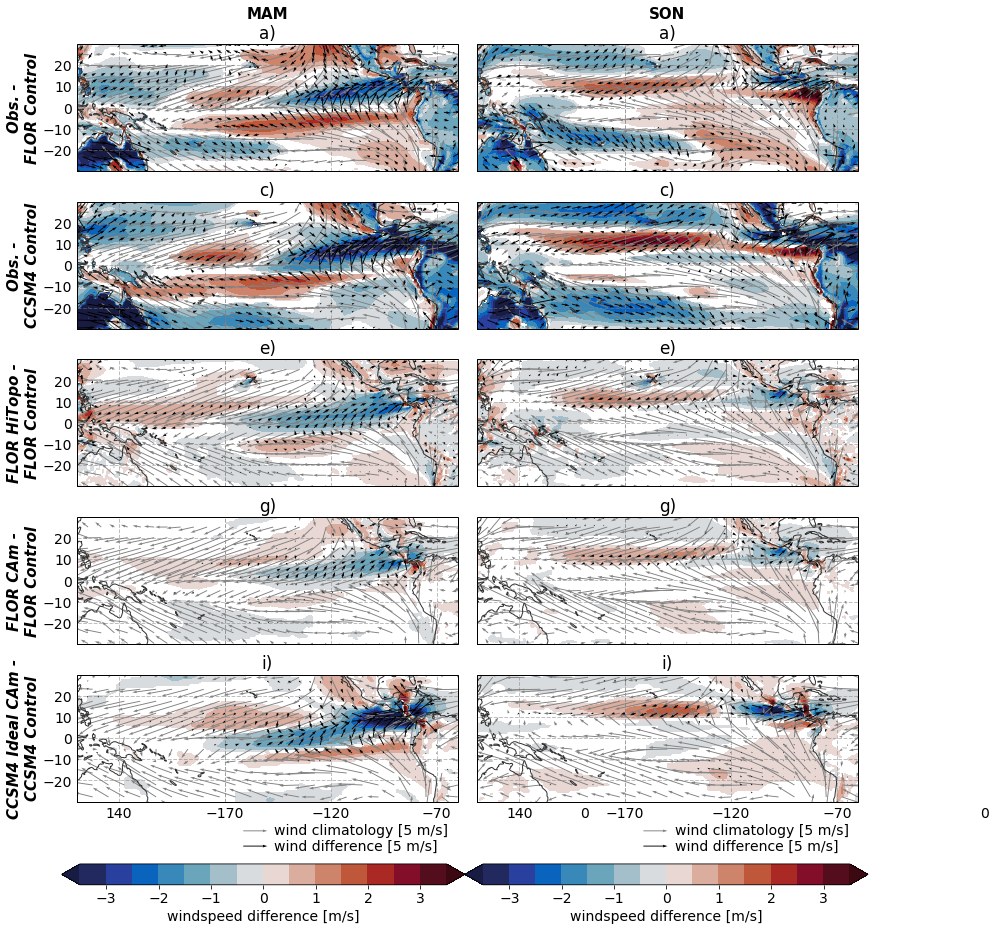

In [11]:
# MAPS COMPARING DIFFERENT MODEL RUNS SEASONAL AVERAGE

fig = plt.figure(figsize=(14,14.5))
plt.rcParams.update({'font.size': 14})
fs_label = 15

lev = np.arange(500,1500,500)
lev2 = np.arange(-3.5,4.0,0.5)
proj = ccrs.PlateCarree(central_longitude=-180)
quivercolor2 = 'k'
topocolor = 'g'
quiverscale = 15
lw = 1
cmap =cmocean.cm.balance

# LAT AND LON
latf = seasmeanu['hitopo'].lat
lonf = seasmeanu['hitopo'].lon
latc = seasmeanu['cesm_cam'].lat
lonc = seasmeanu['cesm_cam'].lon
lato = seasmeanu['obs'].lat
lono = seasmeanu['obs'].lon
# FLOR
n1_flor = 7
n2_flor = 10
x1_flor = lonf[::n1_flor]
y1_flor = latf[::n1_flor]
x2_flor = lonf[::n2_flor]
y2_flor = latf[::n2_flor]
# CCSM4
n1_cesm = 4
n2_cesm = 6
x1_cesm = lonc[::n1_cesm]
y1_cesm = latc[::n1_cesm]
x2_cesm = lonc[::n2_cesm]
y2_cesm = latc[::n2_cesm]
# FLOR vs Obs.
n1_florobs = 7
n2_florobs = 10
x1_florobs = lonf[::n1_florobs]
y1_florobs = latf[::n1_florobs]
x2_florobs = lono[::n2_florobs]
y2_florobs = lato[::n2_florobs]
# CCSM4 vs Obs.
n1_cesmobs = 4
n2_cesmobs = 10
x1_cesmobs = lonc[::n1_cesmobs]
y1_cesmobs = latc[::n1_cesmobs]
x2_cesmobs = lono[::n2_cesmobs]
y2_cesmobs = lato[::n2_cesmobs]


#DIFFERENCES WITH OBS

ax1 = plt.subplot(5,2,1,projection=proj)
ax1.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
CS2 = plt.contourf(lonf,latf,diff_mask_ws['obs']['MAM'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_u['obs']['MAM'][::n1_florobs,::n1_florobs]
v1 = diff_mask_v['obs']['MAM'][::n1_florobs,::n1_florobs]
u2 = np.array(seasmeanu['obs'].sel(season='MAM'))[::n2_florobs,::n2_florobs]
v2 = np.array(seasmeanv['obs'].sel(season='MAM'))[::n2_florobs,::n2_florobs]
q1 = plt.quiver(x2_florobs,y2_florobs,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
q2 = plt.quiver(x1_florobs,y1_florobs,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
ax1.coastlines(color='0.2',linewidth=1)
ax1.set_title('a)')
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax2 = plt.subplot(5,2,2,projection=proj)
ax2.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonf,latf,diff_mask_ws['obs']['SON'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_u['obs']['SON'][::n1_florobs,::n1_florobs]
v1 = diff_mask_v['obs']['SON'][::n1_florobs,::n1_florobs]
u2 = np.array(seasmeanu['obs'].sel(season='SON'))[::n2_florobs,::n2_florobs]
v2 = np.array(seasmeanv['obs'].sel(season='SON'))[::n2_florobs,::n2_florobs]
q1 = plt.quiver(x2_florobs,y2_florobs,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
q2 = plt.quiver(x1_florobs,y1_florobs,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
ax2.coastlines(color='0.2',linewidth=1)
ax2.set_title('a)')
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax3 = plt.subplot(5,2,3,projection=proj)
ax3.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonc,latc,diff_mask_cesm_ws['obs']['MAM'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_cesm_u['obs']['MAM'][::n1_cesmobs,::n1_cesmobs]
v1 = diff_mask_cesm_v['obs']['MAM'][::n1_cesmobs,::n1_cesmobs]
u2 = np.array(seasmeanu['obs'].sel(season='MAM'))[::n2_cesmobs,::n2_cesmobs]
v2 = np.array(seasmeanv['obs'].sel(season='MAM'))[::n2_cesmobs,::n2_cesmobs]
q1 = plt.quiver(x2_cesmobs,y2_cesmobs,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
q2 = plt.quiver(x1_cesmobs,y1_cesmobs,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
ax3.coastlines(color='0.2',linewidth=1)
ax3.set_title('c)')
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax4 = plt.subplot(5,2,4,projection=proj)
ax4.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonc,latc,diff_mask_cesm_ws['obs']['SON'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_cesm_u['obs']['SON'][::n1_cesmobs,::n1_cesmobs]
v1 = diff_mask_cesm_v['obs']['SON'][::n1_cesmobs,::n1_cesmobs]
u2 = np.array(seasmeanu['obs'].sel(season='SON'))[::n2_cesmobs,::n2_cesmobs]
v2 = np.array(seasmeanv['obs'].sel(season='SON'))[::n2_cesmobs,::n2_cesmobs]
q1 = plt.quiver(x2_cesmobs,y2_cesmobs,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
q2 = plt.quiver(x1_cesmobs,y1_cesmobs,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
ax4.coastlines(color='0.2',linewidth=1)
ax4.set_title('c)')
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

# DIFFERENCES BETWEEN MODEL RUNS

ax5 = plt.subplot(5,2,5,projection=proj)
ax5.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonf,latf,diff_mask_ws['hitopo']['MAM'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_u['hitopo']['MAM'][::n1_flor,::n1_flor]
v1 = diff_mask_v['hitopo']['MAM'][::n1_flor,::n1_flor]
u2 = np.array(seasmeanu['ctrl'].sel(season='MAM'))[::n2_flor,::n2_flor]
v2 = np.array(seasmeanv['ctrl'].sel(season='MAM'))[::n2_flor,::n2_flor]
plt.quiver(x2_flor,y2_flor,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
plt.quiver(x1_flor,y1_flor,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
#CS = mdiff_topo['hitopo'].plot.contour(colors=topocolor,levels = lev, transform=ccrs.PlateCarree())
#ax5.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax5.coastlines(color='0.2',linewidth=1)
ax5.set_title('e)')
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax6 = plt.subplot(5,2,6,projection=proj)
ax6.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonf,latf,diff_mask_ws['hitopo']['SON'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_u['hitopo']['SON'][::n1_flor,::n1_flor]
v1 = diff_mask_v['hitopo']['SON'][::n1_flor,::n1_flor]
u2 = np.array(seasmeanu['ctrl'].sel(season='SON'))[::n2_flor,::n2_flor]
v2 = np.array(seasmeanv['ctrl'].sel(season='SON'))[::n2_flor,::n2_flor]
plt.quiver(x2_flor,y2_flor,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
plt.quiver(x1_flor,y1_flor,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
#CS = mdiff_topo['hitopo'].plot.contour(colors=topocolor,levels = lev, transform=ccrs.PlateCarree())
#ax6.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax6.coastlines(color='0.2',linewidth=1)
ax6.set_title('e)')
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax7 = plt.subplot(5,2,7,projection=proj)
ax7.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonf,latf,diff_mask_ws['cam']['MAM'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_u['cam']['MAM'][::n1_flor,::n1_flor]
v1 = diff_mask_v['cam']['MAM'][::n1_flor,::n1_flor]
u2 = np.array(seasmeanu['ctrl'].sel(season='MAM'))[::n2_flor,::n2_flor]
v2 = np.array(seasmeanv['ctrl'].sel(season='MAM'))[::n2_flor,::n2_flor]
plt.quiver(x2_flor,y2_flor,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
plt.quiver(x1_flor,y1_flor,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
#CS = mdiff_topo['cam'].plot.contour(colors=topocolor,levels = lev, transform=ccrs.PlateCarree())
#ax7.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax7.coastlines(color='0.2',linewidth=1)
ax7.set_title('g)')
gl = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax8 = plt.subplot(5,2,8,projection=proj)
ax8.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonf,latf,diff_mask_ws['cam']['SON'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_u['cam']['SON'][::n1_flor,::n1_flor]
v1 = diff_mask_v['cam']['SON'][::n1_flor,::n1_flor]
u2 = np.array(seasmeanu['ctrl'].sel(season='SON'))[::n2_flor,::n2_flor]
v2 = np.array(seasmeanv['ctrl'].sel(season='SON'))[::n2_flor,::n2_flor]
plt.quiver(x2_flor,y2_flor,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
plt.quiver(x1_flor,y1_flor,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
#CS = mdiff_topo['cam'].plot.contour(colors=topocolor,levels = lev, transform=ccrs.PlateCarree())
#ax8.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax8.coastlines(color='0.2',linewidth=1)
ax8.set_title('g)')
gl = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

# CCSM4

ax9 = plt.subplot(5,2,9,projection=proj)
ax9.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonc,latc,diff_mask_ws['cesm_cam']['MAM'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_u['cesm_cam']['MAM'][::n1_cesm,::n1_cesm]
v1 = diff_mask_v['cesm_cam']['MAM'][::n1_cesm,::n1_cesm]
u2 = np.array(seasmeanu['cesm_ctrl'].sel(season='MAM'))[::n2_cesm,::n2_cesm]
v2 = np.array(seasmeanv['cesm_ctrl'].sel(season='MAM'))[::n2_cesm,::n2_cesm]
q1 = plt.quiver(x2_cesm,y2_cesm,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
q2 = plt.quiver(x1_cesm,y1_cesm,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
#CS = mdiff_topo['cesm_cam'].plot.contour(colors=topocolor,levels = lev, transform=ccrs.PlateCarree())
ax9.quiverkey(q1,0.5,-0.23,5,'wind climatology [5 m/s]',coordinates='axes',labelpos='E')
ax9.quiverkey(q2,0.5,-0.35,5,'wind difference [5 m/s]',coordinates='axes',labelpos='E')
#ax9.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax9.coastlines(color='0.2',linewidth=1)
ax9.set_title('i)')
gl = ax9.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

ax10 = plt.subplot(5,2,10,projection=proj)
ax10.set_extent([120, 300, -30, 30], ccrs.PlateCarree())
plt.contourf(lonc,latc,diff_mask_ws['cesm_cam']['SON'],levels=lev2,cmap=cmap,transform=ccrs.PlateCarree(),extend='both')
u1 = diff_mask_u['cesm_cam']['SON'][::n1_cesm,::n1_cesm]
v1 = diff_mask_v['cesm_cam']['SON'][::n1_cesm,::n1_cesm]
u2 = np.array(seasmeanu['cesm_ctrl'].sel(season='SON'))[::n2_cesm,::n2_cesm]
v2 = np.array(seasmeanv['cesm_ctrl'].sel(season='SON'))[::n2_cesm,::n2_cesm]
q1 = plt.quiver(x2_cesm,y2_cesm,u2,v2,transform=ccrs.PlateCarree(),color='0.5',units='inches',scale=quiverscale)
q2 = plt.quiver(x1_cesm,y1_cesm,u1,v1,transform=ccrs.PlateCarree(),color=quivercolor2,units='inches',scale=quiverscale)
#CS = mdiff_topo['cesm_cam'].plot.contour(colors=topocolor,levels = lev, transform=ccrs.PlateCarree())
q1 = ax10.quiverkey(q1,0.5,-0.23,5,'wind climatology [5 m/s]',coordinates='axes',labelpos='E')
q2 = ax10.quiverkey(q2,0.5,-0.35,5,'wind difference [5 m/s]',coordinates='axes',labelpos='E')
#ax10.clabel(CS, fontsize=9, inline=1, fmt = '%1.f')
ax10.coastlines(color='0.2',linewidth=1)
ax10.set_title('i)')
gl = ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=lw, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator([140,190,-170,-120,-70,0])
gl.ylocator = mticker.FixedLocator([-30,-20,-10,0,10,20,30])

fig.subplots_adjust(wspace=0.05,hspace=0.0)

#colorbars
fig.subplots_adjust(wspace=0.05, hspace=0.0)
cb2_ax = fig.add_axes([0.11, 0.06, 0.4, 0.02])
cb2 = fig.colorbar(CS2, cax=cb2_ax, orientation='horizontal')
cb2.ax.set_xlabel('windspeed difference [m/s]')

cb2_ax = fig.add_axes([0.51, 0.06, 0.4, 0.02])
cb2 = fig.colorbar(CS2, cax=cb2_ax, orientation='horizontal')
cb2.ax.set_xlabel('windspeed difference [m/s]')

#labels
ax1.text(0.5,1.2,'MAM',fontsize = fs_label, transform=ax1.transAxes, horizontalalignment='center', fontweight='bold')
ax2.text(0.5,1.2,'SON',fontsize = fs_label, transform=ax2.transAxes, horizontalalignment='center', fontweight='bold')

ax1.text(-0.14,0.5,'Obs. -\nFLOR Control',fontsize = fs_label, style = 'italic', transform=ax1.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
ax3.text(-0.14,0.5,'Obs. -\nCCSM4 Control',fontsize = fs_label, style = 'italic', transform=ax3.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
ax5.text(-0.14,0.5,'FLOR HiTopo -\nFLOR Control',fontsize = fs_label, style = 'italic',transform=ax5.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
ax7.text(-0.14,0.5,'FLOR CAm -\nFLOR Control',fontsize = fs_label, style = 'italic', transform=ax7.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
ax9.text(-0.14,0.5,'CCSM4 Ideal CAm -\nCCSM4 Control',fontsize = fs_label, style = 'italic', transform=ax9.transAxes, rotation = 90, verticalalignment='center', ha = 'center', fontweight='bold')
#plt.tight_layout()

#plt.savefig('winds_map_mam-son_pluscesm.png',dpi = 600)
#plt.savefig('winds_map_mam-son_pluscesm.pdf')